In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

NUM_MODELS=500
NOISE_DIM= 50
BATCH_SIZE= 1
ROW= 2 # Row number in text file


Device: cuda


In [2]:
#Dataset
def parse_complex_number(s):
    s = s.replace("+-", "-")  # Ensure proper formatting

    # Case 1: Complex number with real and imaginary parts (e.g., "-0.2951-0.4833i")
    complex_match = re.match(r'([+-]?\d*\.?\d+)([+-]\d*\.?\d+)i$', s)
    if complex_match:
        real_part = float(complex_match.group(1))  
        imag_part = float(complex_match.group(2))  
        return complex(real_part, imag_part)

    # Case 2: Pure imaginary number (e.g., "0.0i", "-0.0i")
    imag_match = re.match(r'([+-]?\d*\.?\d+)i$', s)
    if imag_match:
        return complex(0.0, float(imag_match.group(1)))

    # Case 3: Pure real number (e.g., "0", "-0", "0.0")
    real_match = re.match(r'([+-]?\d*\.?\d+|0)$', s)
    if real_match:
        return complex(float(real_match.group(1)), 0.0)

    raise ValueError(f"Invalid complex number format: {s}")

# -----------------------------------
# Load & Parse Complex Spectra Data
# -----------------------------------
spectra_file = "Gen2_datasets/Test_label_complex_V1.txt"

with open(spectra_file, 'r') as file:
    lines = file.readlines()

# Convert each string number into a complex number
complex_numbers = []
for line in lines:
    for num in line.strip().split():
        try:
            complex_numbers.append(parse_complex_number(num))
        except ValueError as e:
            print(f"Skipping invalid entry: {num}")  # Debugging help

# Extract Real and Imaginary Components
real_parts = np.array([num.real for num in complex_numbers], dtype=np.float32)
imag_parts = np.array([num.imag for num in complex_numbers], dtype=np.float32)

# Reshape into Expected Format (assuming each row contains 64 values)
spectra_real = real_parts.reshape(-1, 64)
spectra_imag = imag_parts.reshape(-1, 64)

# Print shapes for verification
print(f"Spectra Real Shape: {spectra_real.shape}")  
print(f"Spectra Imag Shape: {spectra_imag.shape}")

#****************************************Dataset preparation*****************************************
class SpectraToImageDataset(Dataset):
    def __init__(self, spectra_real, spectra_imag):

        self.spectra_real = torch.tensor(spectra_real, dtype=torch.float32)
        self.spectra_imag = torch.tensor(spectra_imag, dtype=torch.float32)
        
        
        
        assert len(self.spectra_real) == len(self.spectra_imag) , "Mismatch in dataset sizes!"
        
    def __len__(self):
        return len(self.spectra_real)
    
    def __getitem__(self, idx):
        real_part = self.spectra_real[idx]
        imag_part = self.spectra_imag[idx]
        spectrum = torch.cat((real_part, imag_part), dim=0) 
        
        
        return spectrum



dataset = SpectraToImageDataset(spectra_real, spectra_imag) 


test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)


Spectra Real Shape: (150, 64)
Spectra Imag Shape: (150, 64)


In [3]:
# model

#Generator
class Generator(nn.Module):
    def __init__(self, noise_dim=NOISE_DIM, spectra= 128 ):
        super(Generator, self).__init__()
        input_dim = + spectra + noise_dim 

        self.fc = nn.Linear(input_dim, 512 * 4 * 4)

        self.generator = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),  # 4x4 → 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # 8x8 → 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # 16x16 → 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),  # 32x32 → 64x64
            nn.Tanh()  # Normalize output to range [-1,1]
        )

    def forward(self, spectra, noise):
        x = torch.cat([spectra, noise], dim=1)  # Shape: [batch, 178]
        x = self.fc(x)                            # [batch, 512*4*4]
        x = x.view(-1, 512, 4, 4)                 # Reshape to conv input
        return self.generator(x)                     # Output: [batch, 1, 64, 64]

#Simulator
class ResNetBlock1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.identity_downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1,stride=1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        if self.identity_downsample is not None:
            identity = self.identity_downsample(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out


# Define ResNetBlock2
class ResNetBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        if self.conv3 is not None:
            identity = self.conv3(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out


# Define the entire network
class FinalCNN(nn.Module):
    def __init__(self):
        super(FinalCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = ResNetBlock1(in_channels=64, out_channels=64)
        self.layer2 = ResNetBlock2(in_channels=64, out_channels=128)
        self.layer3 = ResNetBlock1(in_channels=128, out_channels=256)
        self.layer4 = ResNetBlock2(in_channels=256, out_channels=128)
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 128)
        #self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 128)  # 64 for real and 64 for imaginary

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = torch.tanh(self.fc3(x))  # Clamping the output to be within [-1, 1]
        return x

Epoch 1: MSE = 0.06755803525447845
Epoch 2: MSE = 0.07817216217517853
Epoch 3: MSE = 0.09582285583019257
Epoch 4: MSE = 0.09164249897003174
Epoch 5: MSE = 0.07244337350130081
Epoch 6: MSE = 0.056058965623378754
Epoch 7: MSE = 0.08109307289123535
Epoch 8: MSE = 0.0810113400220871
Epoch 9: MSE = 0.05804431065917015
Epoch 10: MSE = 0.049309104681015015
Epoch 11: MSE = 0.08244571089744568
Epoch 12: MSE = 0.05433987081050873
Epoch 13: MSE = 0.043916866183280945
Epoch 14: MSE = 0.039219729602336884
Epoch 15: MSE = 0.060432832688093185
Epoch 16: MSE = 0.04597091302275658
Epoch 17: MSE = 0.07381407916545868
Epoch 18: MSE = 0.056976318359375
Epoch 19: MSE = 0.05246547609567642
Epoch 20: MSE = 0.06552210450172424
Epoch 21: MSE = 0.036715999245643616
Epoch 22: MSE = 0.06512825936079025
Epoch 23: MSE = 0.07489119470119476
Epoch 24: MSE = 0.07760979980230331
Epoch 25: MSE = 0.03927838057279587
Epoch 26: MSE = 0.018618397414684296
Epoch 27: MSE = 0.07455778121948242
Epoch 28: MSE = 0.079930201172828

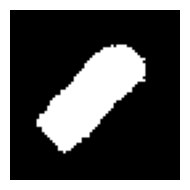

In [4]:
simulator_path = 'Gen2_datasets/model_28_1039.pth'
simulator = FinalCNN().to(DEVICE)
simulator.load_state_dict(torch.load(simulator_path, map_location=DEVICE))
simulator.eval()
   
    
# Load and compare all models in the specified directory
def load_and_compare_models(simulator, test_loader, row, num_models, noise_dim, batch_size, device):
    all_mse = []
    best_image = None  # To store the generated image corresponding to the best MSE
    best_mse = float('inf')  # Initialize with a large number
    best_epoch = None
    for epoch in range(1, num_models+1):  # Loop over all saved models
        
        model_path = f"GDS_V2_Copy/Generator_{epoch}.pt"
        generator= Generator().to(device)
        generator.load_state_dict(torch.load(model_path, map_location= device))
        generator.eval()
        
        for batch_idx, actual_spectra in enumerate(test_loader):
            if batch_idx == row-1:  # 50th sample (0-based index)
                actual_spectra = actual_spectra.to(device)
                '''
                print(f"Batch {batch_idx + 1}:")
                print(f"Shape of batch: {actual_spectra.shape}")
                print(f"spectra: {actual_spectra}")
                '''
                noise=torch.randn(batch_size, noise_dim, device= device)
        
                Gen_img= generator(actual_spectra, noise)
        
                Gen_img_N= torch.where(Gen_img > 0, torch.tensor(1.0, device=device), torch.tensor(-1.0, device=device)) #map into -1 or 1
            
                Gen_img_B= (Gen_img_N + 1) / 2.0 #Denormalize to 0 or 1 for simulator
        
                Sim_spectra = simulator(Gen_img_B.to(device))
        
                MSE_Loss = torch.nn.MSELoss()(Sim_spectra, actual_spectra).item()
        
                all_mse.append((epoch, MSE_Loss))
                if MSE_Loss < best_mse:
                    best_mse = MSE_Loss
                    best_epoch = epoch
                    best_image = Gen_img_B.detach().cpu()  # Detach and move to CPU for saving
                    
                print(f"Epoch {epoch}: MSE = {MSE_Loss}")
                break  # Stop after processing the 50th sample
    # Find the model with the smallest MSE (best match)
    #best_epoch, best_mse = min(all_mse, key=lambda x: x[1])
    print(f"Best model: Epoch {best_epoch} with MSE = {best_mse}")
    
# visualize the image and save in a text file
    if best_image is not None:
        
        image_to_display = best_image[0].permute(1, 2, 0).squeeze()
        fig, ax = plt.subplots(figsize=(2, 2))
    
        # Display the binary image in grayscale
        ax.imshow(image_to_display, cmap='gray')
        ax.axis('off')  # Hide the axes
        plt.tight_layout()  # Adjust layout to avoid overlap
        plt.show()
        
        filename=f"M{row}.txt"
        reshaped_images = image_to_display.reshape(64, 64)  
        np.savetxt(filename, reshaped_images, fmt='%d', delimiter=',')

# Call the function to compare all models
load_and_compare_models(simulator,test_loader, ROW, NUM_MODELS, NOISE_DIM, BATCH_SIZE, DEVICE)